# Chapter 1: Introduction

---

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

### Finding Key Connectors

In [2]:
# List of users

users = [
    {"id": 0, "name": "Hero"},
    {"id": 1, "name": "Dunn"},
    {"id": 2, "name": "Sue"},
    {"id": 3, "name": "Chi"},
    {"id": 4, "name": "Thor"},
    {"id": 5, "name": "Clive"},
    {"id": 6, "name": "Hicks"},
    {"id": 7, "name": "Devin"},
    {"id": 8, "name": "Kate"},
    {"id": 9, "name": "Klein"}
]

In [3]:
# Friendship data, represented as a list of pairs of IDs

friendships = [(0, 1), (0, 2), (1, 2), (1, 3), (2, 3), (3, 4),
               (4, 5), (5, 6), (5, 7), (6, 8), (7, 8), (8, 9)]

I will try to create a representation of this network, like the one shown in the book. 
For this, I'm going to use the networkx package, which is already imported as nx. 

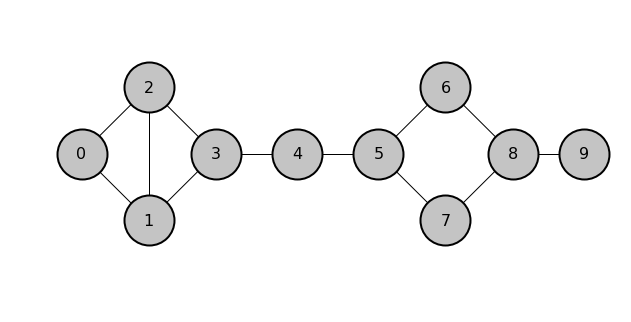

In [4]:
# Create an empty graph structure (a "null graph") with no nodes and no edges
G = nx.Graph()

# Add edges to the graph using friendships list. Each pair of friends (each tuple)
# in friendships forms an edge
G.add_edges_from(friendships)

# Creates a dictionary of positions keyed by node to use later in nx.draw()
#pos = nx.spring_layout(G)
pos = {0: [-1.00,  0.00],
       1: [-0.72, -0.09],
       2: [-0.72,  0.09],
       3: [-0.44,  0.00],
       4: [-0.10,  0.00],
       5: [ 0.24,  0.00],
       6: [ 0.52,  0.09],
       7: [ 0.52, -0.09],
       8: [ 0.80,  0.00],
       9: [ 1.10,  0.00]}

# Creates a new figure and specify its size
plt.figure(figsize=(8,4))   

# Draw the graph G
nx.draw(G, pos, with_labels=True, node_color='#C4C4C4', node_size=2500,
        font_size=16, linewidths=2)

# Change the color of the nodes' outline
ax = plt.gca()                            # to get the current axis
ax.collections[0].set_edgecolor('black')  # ax.collections[0] is a PathCollection object governing the nodes

# display figure
plt.show()

*Figure 1-1. The DataSciencester network*

In [5]:
# Let's add a list (empty for now) of friends to each user

for user in users:
    user["friends"] = []
    
# Now, we populate the list using the friendships data

for i, j in friendships:
    users[i]["friends"].append(users[j])  # add j as a friend of i
    users[j]["friends"].append(users[i])  # add i as a friend of j

Now, we can ask: what's the average number of connections?

In [6]:
# First we find the total number of connections, by summing up the lengths of all the friends lists:

def number_of_friends(user):
    #how many friends does _user_ have?
    return len(user["friends"])

total_connections = sum(number_of_friends(user)
                        for user in users)         # 24

# Then we divide by the number of users:

num_users = len(users)                             # length of the users list
avg_connections = total_connections / num_users    # 2.4

Let's find now the most connected people. We can sort the users from "most friends" to "least friends":

In [7]:
# Create a list (user_id, number_of_friends)
num_friends_by_id = [(user["id"], number_of_friends(user))
                      for user in users]

sorted(num_friends_by_id,                          # get it sorted 
       key=lambda user_friends: user_friends[1],   # by number of friends. Different from the book, which uses Python2. In Python3, tuple parameter unpacking is not supported anymore.
       reverse=True)                               # largest to smallest

[(1, 3),
 (2, 3),
 (3, 3),
 (5, 3),
 (8, 3),
 (0, 2),
 (4, 2),
 (6, 2),
 (7, 2),
 (9, 1)]

We've just identified people who are somehow central to the network. In fact, we computed
the network metric *degree centrality* (Figure 1-2).

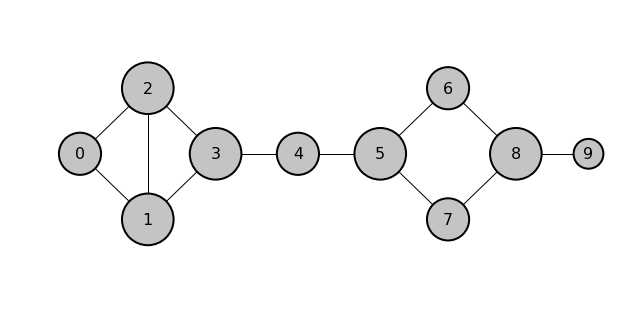

In [8]:
dc = nx.degree_centrality(G)              # dictionary with nodes as keys and degree centrality as values
dc_array = np.array(list(dc.values()))    # numpy array with degree centrality values. This will be used
                                          # in the node_size parameter of nx.draw

# Creates a dictionary of positions keyed by node to use later in nx.draw()
#pos = nx.spring_layout(G)
pos = {0: [-1.00,  0.00],
       1: [-0.72, -0.09],
       2: [-0.72,  0.09],
       3: [-0.44,  0.00],
       4: [-0.10,  0.00],
       5: [ 0.24,  0.00],
       6: [ 0.52,  0.09],
       7: [ 0.52, -0.09],
       8: [ 0.80,  0.00],
       9: [ 1.10,  0.00]}

# Creates a new figure and specify its size
plt.figure(figsize=(8,4))                 

# Draw the graph G 
nx.draw(G, pos, with_labels=True, node_color='#C4C4C4', node_size=8000*dc_array,
        font_size=16, linewidths=2)

# Change the color of the nodes' outline
ax = plt.gca()                            # to get the current axis
ax.collections[0].set_edgecolor('black')  # ax.collections[0] is a PathCollection object governing the nodes

# Display figure
plt.show()

*Figure 1-2. The DataSciencester network sized by degree*

### Data Scientists You May Know

Now we will construct a "Data Scientists You May Know" suggester.

In [9]:
# A user might know the friends of friends. So, for each of a user's friends, iterate over that person's friends
# and collect all the results

def friends_of_friend_ids_bad(user):
    # "foaf" is short for "friend of a friend"
    return [foaf["id"]
            for friend in user["friends"]    # for each of user's friends
            for foaf in friend["friends"]]   # get each of _their_ friends

In [10]:
# Calling this function on users[0] (Hero)
friends_of_friend_ids_bad(users[0])

[0, 2, 3, 0, 1, 3]

It includes 0 twice, since Hero is friends with both of his friends. It includes users 1 and 2, although they are both friends with Hero already. And it includes user 3 twice, as Chi is reachable through two different friends.<br>
Maybe we should produce a *count* of mutual friends. We also should use a helper function to exclude people already know to the user:

In [11]:
from collections import Counter     # not loaded by default

def not_the_same(user, other_user):
    # two users are not the same if they have different ids
    return user["id"] != other_user["id"]

def not_friends(user, other_user):
    # other user is not a friend if he's not in user["friends"],
    # that is, if he's not_the_same as all the people in user["friends"]
    return all(not_the_same(friend, other_user)
               for friend in user["friends"])

def friends_of_friend_ids(user):
    return Counter(foaf["id"]
                   for friend in user["friends"]    # for each of my friends
                   for foaf in friend["friends"]    # count *their* friends
                   if not_the_same(user, foaf)      # who aren't me
                   and not_friends(user, foaf))     # and aren't my friends

print(friends_of_friend_ids(users[3]))              # Counter({0: 2, 5: 1})

Counter({0: 2, 5: 1})


You are interested in meeting users with similar interests, so you manage to get your hands on this data as a list of pairs (user_id, interest):

In [12]:
interests = [
    (0, "Hadoop"), (0, "Big Data"), (0, "HBase"), (0, "Java"),
    (0, "Spark"), (0, "Storm"), (0, "Cassandra"),
    (1, "NoSQL"), (1, "MongoDB"), (1, "Cassandra"), (1, "HBase"),
    (1, "Postgres"), (2, "Python"), (2, "scikit-learn"), (2, "scipy"),
    (2, "numpy"), (2, "statsmodels"), (2, "pandas"), (3, "R"), (3, "Python"),
    (3, "statistics"), (3, "regression"), (3, "probability"),
    (4, "machine learning"), (4, "regression"), (4, "decision trees"),
    (4, "libsvm"), (5, "Python"), (5, "R"), (5, "Java"), (5, "C++"),
    (5, "Haskell"), (5, "programming languages"), (6, "statistics"),
    (6, "probability"), (6, "mathematics"), (6, "theory"),
    (7, "machine learning"), (7, "scikit-learn"), (7, "Mahout"),
    (7, "neural networks"), (8, "neural networks"), (8, "deep learning"),
    (8, "Big Data"), (8, "artificial intelligence"), (9, "Hadoop"),
    (9, "Java"), (9, "MapReduce"), (9, "Big Data")
]

Now we build a function that finds users with a certain interest:

In [13]:
def data_scientists_who_like(target_interest):
    return [user_id
            for user_id, user_interest in interests
            if user_interest == target_interest]

This works, but it has to examine the whole list of interests for every search. If we have a lot of users and interests, or if we want to do a lot of searches, it's probably better building an index from interests to users:

In [14]:
from collections import defaultdict   # we're going to use the defaultdict dict subclass 

# keys are interests, values are lists of user_ids with that interest
user_ids_by_interest = defaultdict(list)

for user_id, interest in interests:
    user_ids_by_interest[interest].append(user_id)

user_ids_by_interest

defaultdict(list,
            {'Big Data': [0, 8, 9],
             'C++': [5],
             'Cassandra': [0, 1],
             'HBase': [0, 1],
             'Hadoop': [0, 9],
             'Haskell': [5],
             'Java': [0, 5, 9],
             'Mahout': [7],
             'MapReduce': [9],
             'MongoDB': [1],
             'NoSQL': [1],
             'Postgres': [1],
             'Python': [2, 3, 5],
             'R': [3, 5],
             'Spark': [0],
             'Storm': [0],
             'artificial intelligence': [8],
             'decision trees': [4],
             'deep learning': [8],
             'libsvm': [4],
             'machine learning': [4, 7],
             'mathematics': [6],
             'neural networks': [7, 8],
             'numpy': [2],
             'pandas': [2],
             'probability': [3, 6],
             'programming languages': [5],
             'regression': [3, 4],
             'scikit-learn': [2, 7],
             'scipy': [2],
             's

And another from users to interests:

In [15]:
# keys are user_ids, values are lists of interests for that user_id
interests_by_user_id = defaultdict(list)

for user_id, interest in interests:
    interests_by_user_id[user_id].append(interest)

interests_by_user_id

defaultdict(list,
            {0: ['Hadoop',
              'Big Data',
              'HBase',
              'Java',
              'Spark',
              'Storm',
              'Cassandra'],
             1: ['NoSQL', 'MongoDB', 'Cassandra', 'HBase', 'Postgres'],
             2: ['Python',
              'scikit-learn',
              'scipy',
              'numpy',
              'statsmodels',
              'pandas'],
             3: ['R', 'Python', 'statistics', 'regression', 'probability'],
             4: ['machine learning', 'regression', 'decision trees', 'libsvm'],
             5: ['Python',
              'R',
              'Java',
              'C++',
              'Haskell',
              'programming languages'],
             6: ['statistics', 'probability', 'mathematics', 'theory'],
             7: ['machine learning',
              'scikit-learn',
              'Mahout',
              'neural networks'],
             8: ['neural networks',
              'deep learning',
       

Now it's easy to find who has the most interests in common with a given user:
- Iterate over the user's interests.
- For each interest, iterate over the others users with that interest.
- Keep count how many times we see each other user.

In [16]:
def most_common_interests_with(user):
    return Counter(interested_user_id
        for interest in interests_by_user_id[user["id"]]
        for interested_user_id in user_ids_by_interest[interest]
        if interested_user_id != user["id"])

This could be used to build a richer "Data Scientists You May Know" feature based on a combination of mutual friends and mutual interests.

### Salaries and Experience

In [128]:
# The limits are −2,147,483,648 and 2,147,483,647. The hex values of them are -0x80000000 and 0x7fffffff.
# You can see that, for positive values: 
# 2147483647 & 0x7fffffff = 2147483647; 1 & 0x7fffffff = 1; 780 & 0x7fffffff = 780
# where '&' is the 'bitwise AND' operator.
# That is, for values within the limit, the value is given as output.
# And:
# 2147483648 & 0x7fffffff = 0; 98989898989898 & 0x7fffffff = 1640235338
# That is, for values exceeding the limit, some other value is displayed.

# For negative values:
# -2147483648 & -0x80000000 = -2147483648; -2147483647 & -0x80000000 = -2147483648; -2 & -0x80000000 = -2147483648
# That is, for values within the limit, the limit is given as output.
# And:
# -2147483649 & -0x80000000 = -4294967296; -999999999999 & -0x80000000 = -1000727379968
# That is, for values exceeding the limit, some other value is displayed.

# We can use this to solve the problem.


class Solution:
    def reverse(self, x):
        self.x = str(x)
         
        if x >= 0 and (int(self.x[::-1]) & 0x7fffffff == int(self.x[::-1])):
            return int(self.x[::-1])
        elif x < 0 and (-int(self.x[:0:-1]) & -0x80000000 == -0x80000000):
            return -int(self.x[:0:-1])
        else:
            return 0

In [131]:
ob = Solution()
ob.reverse(-1234)

-4321

In [149]:
 def reverse(x):
        str_x = str(x)
         
        if x >= 0 and (int(str_x[::-1]) & 0x7fffffff == int(str_x[::-1])):
            return int(str_x[::-1])
        elif x < 0 and (-int(str_x[:0:-1]) & -0x80000000 == -0x80000000):
            return -int(str_x[:0:-1])
        else:
            return 0

In [155]:
reverse(-1230)

-321

In [340]:
class Solution:
    def reverse(self, x):
        str_x = str(x)
        
        if (-2**31) <= int(str_x[::-1]) <= (2**31-1):
            return int(str_x[::-1])
        elif x < 0 and -int(str_x[:0:-1]) >= (-2**31):
            

In [345]:
abs(10)

10